In [70]:
## Importing the base libraries

import pandas as pd
import numpy as np
import datetime
import itertools

##Importing the libraries requried for plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Importing libraries for Network building and Geohash calibration
import networkx as nx
import pygeohash as gh

##Importing libraries for regression and time-series model
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA

In [168]:


from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

In [160]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

#from tf.keras.models import Sequential  #This does not work!
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2]:
df_training = pd.read_csv('training.csv')

In [165]:
day_traffic = df_training.groupby(['day'])['demand'].agg({'cum_demand':'sum'})
day_traffic.reset_index(inplace = True)

In [5]:
np.sort(df_training['timestamp'].unique())

array(['0:0', '0:15', '0:30', '0:45', '10:0', '10:15', '10:30', '10:45',
       '11:0', '11:15', '11:30', '11:45', '12:0', '12:15', '12:30',
       '12:45', '13:0', '13:15', '13:30', '13:45', '14:0', '14:15',
       '14:30', '14:45', '15:0', '15:15', '15:30', '15:45', '16:0',
       '16:15', '16:30', '16:45', '17:0', '17:15', '17:30', '17:45',
       '18:0', '18:15', '18:30', '18:45', '19:0', '19:15', '19:30',
       '19:45', '1:0', '1:15', '1:30', '1:45', '20:0', '20:15', '20:30',
       '20:45', '21:0', '21:15', '21:30', '21:45', '22:0', '22:15',
       '22:30', '22:45', '23:0', '23:15', '23:30', '23:45', '2:0', '2:15',
       '2:30', '2:45', '3:0', '3:15', '3:30', '3:45', '4:0', '4:15',
       '4:30', '4:45', '5:0', '5:15', '5:30', '5:45', '6:0', '6:15',
       '6:30', '6:45', '7:0', '7:15', '7:30', '7:45', '8:0', '8:15',
       '8:30', '8:45', '9:0', '9:15', '9:30', '9:45'], dtype=object)

### Plotting aggregated demand graph - for office to & fro traffic

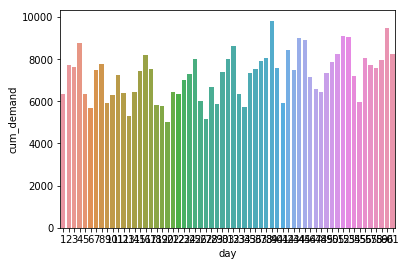

In [6]:
sns.barplot(x = 'day',
            y = 'cum_demand',
            data  = day_traffic
           )

/Users/harshil.parashar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


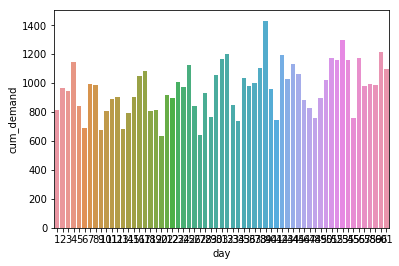

In [7]:
## identifying weekend and weekday traffic
office_going = ['8:0', '8:15','8:30', '8:45', '9:0', '9:15', '9:30', '9:45']
office_returning = ['18:0', '18:15', '18:30', '18:45', '19:0', '19:15', '19:30','19:45']

office_going_traffic = df_training[df_training['timestamp'].isin(office_going)].groupby(['day'])['demand'].agg({'cum_demand':'sum'})

office_going_traffic.reset_index(inplace=True)

sns.barplot(x = 'day',
            y = 'cum_demand',
            data  = office_going_traffic
           )

/Users/harshil.parashar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


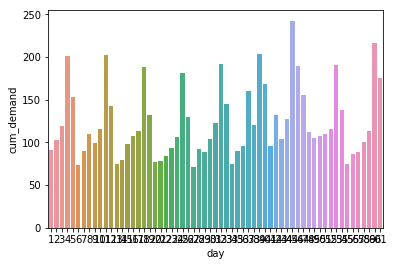

In [8]:
office_returning_traffic = df_training[df_training['timestamp'].isin(office_returning)].groupby(['day'])['demand'].agg({'cum_demand':'sum'})
office_returning_traffic.reset_index(inplace=True)
sns.barplot(x = 'day',
            y = 'cum_demand',
            data  = office_returning_traffic
           )

### Identifying a clear pattern in aggregate demand - repeating with a frequency of 6/7 days. Weekend and Weekdays can be identified

In [9]:
weekend_arr__ = [5,6,12,13,19,20,26,27,33,34,40,41,47,48,54,55,61]
df_training['is_weekend'] = df_training['day'].apply(lambda x: x in weekend_arr__)

## Converting Geohash to lat-long

In [10]:
df_training['lat'] = df_training['geohash6'].apply(lambda x: gh.decode_exactly(x)[0]).astype('float64')
df_training['long'] = df_training['geohash6'].apply(lambda x: gh.decode_exactly(x)[1]).astype('float64')

## Leveraging graph theory to identify the network structure

In [11]:
geohash_list = df_training['geohash6'].unique()

In [12]:
df = []

for elem in geohash_list:
    for other_elem in geohash_list:
        d = {'from_geohash':elem, 
                 'to_geohash':other_elem, 
                 'distance':gh.geohash_approximate_distance(elem,other_elem)/1000}
        df.append(d)

df_temp = pd.DataFrame(df)

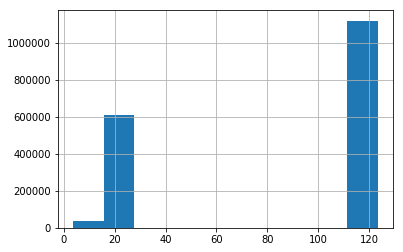

In [13]:
df_temp = df_temp[df_temp['distance'] != 0.610]
df_temp.distance.hist()

In [14]:
df_temp.distance.value_counts()

123.264    1118786
19.545      611186
3.803        34940
Name: distance, dtype: int64

#### The geohash are on 3 levels - at distance of 3.803, 19.545 and 123.264 km. Using graph theory we try and identify how the geohash at 3.803 kms are connected to one another

In [15]:
df_temp_close = df_temp[df_temp['distance'] == 3.803]

## Building a network of closely connected geohash

In [16]:
list_from_nodes = df_temp_close.from_geohash.unique()
edges = df_temp_close[['from_geohash','to_geohash']]

In [17]:
G = nx.DiGraph()
G.add_nodes_from(list_from_nodes)
G = nx.from_pandas_edgelist(edges, 'from_geohash','to_geohash')

/Users/harshil.parashar/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


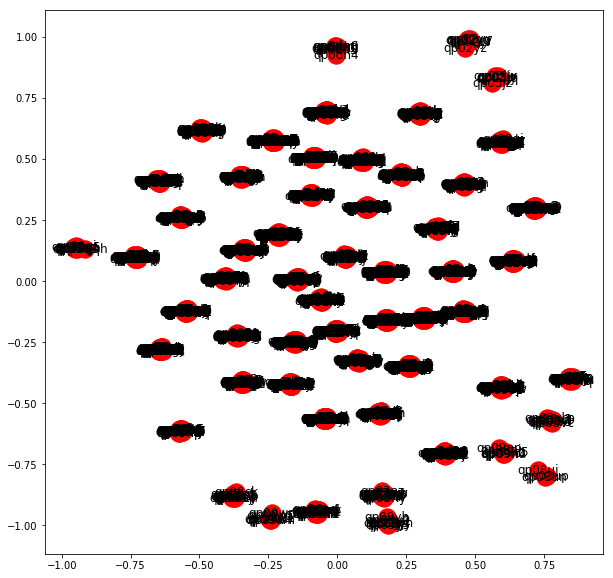

In [18]:
plt.figure(3, figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx(G)

plt.show()


### From this network graph we can conclude that there are cluster of areas close to each other

#### Expected from hash value data

## Preparing data for time based models

In [19]:
df_training['hour'] = df_training['timestamp'].apply(lambda x: x.split(':')[0]).astype('float64')
df_training['min'] = df_training['timestamp'].apply(lambda x: x.split(':')[1]).astype('float64')

In [20]:
df_training['day'] = df_training['day'].astype('float64')

In [21]:
df_training.head()

,geohash6,day,timestamp,demand,is_weekend,lat,long,hour,min
0,qp03wc,18.0,20:0,0.020072,False,-5.353088,90.653687,20.0,0.0
1,qp03pn,10.0,14:30,0.024721,False,-5.413513,90.664673,14.0,30.0
2,qp09sw,9.0,6:15,0.102821,False,-5.325623,90.906372,6.0,15.0
3,qp0991,32.0,5:0,0.088755,False,-5.353088,90.752563,5.0,0.0
4,qp090q,15.0,4:0,0.074468,False,-5.413513,90.719604,4.0,0.0


df_training['date_time_2'] = df_training['day'].apply(lambda x: date_base+ timedelta(days = x))
df_training['date_time_2'] = df_training[['date_time_2','hour']].apply(lambda x: x.date_time_2 + 
                                                                         timedelta(hours = x.hour), axis = 1)
df_training['date_time_2'] = df_training[['date_time_2','min']].apply(lambda x: x.date_time_2.timedelta(minutes = x.min), axis = 1)

In [22]:
df_training['time_in_mins'] = 1440 * df_training['day'] + 60* df_training['hour'] + df_training['min']

In [23]:
df_training.sort_values(['day','hour','min'], ascending = True).head()

,geohash6,day,timestamp,demand,is_weekend,lat,long,hour,min,time_in_mins
2289,qp09sx,1.0,0:0,0.021212,False,-5.320129,90.906372,0.0,0.0,1440.0
3149,qp0dhg,1.0,0:0,0.013217,False,-5.254211,90.917358,0.0,0.0,1440.0
11052,qp03x5,1.0,0:0,0.157956,False,-5.342102,90.664673,0.0,0.0,1440.0
23011,qp09bw,1.0,0:0,0.001262,False,-5.281677,90.730591,0.0,0.0,1440.0
26180,qp03wn,1.0,0:0,0.032721,False,-5.325623,90.620728,0.0,0.0,1440.0


## Building a 2-degree hash of nodes connected to one another identifying geohash6 on top/bottom/left/right to each other

In [27]:
long_list = pd.DataFrame(np.sort(df_training['long'].unique())).reset_index()
long_list.columns = ['long_rank','long']

In [28]:
lat_list = pd.DataFrame(np.sort(df_training['lat'].unique())).reset_index()
lat_list.columns = ['lat_rank','lat']

In [29]:
df_training = pd.merge(left = df_training,
                      right = lat_list,
                      how = 'left',
                      left_on='lat',
                      right_on='lat')

In [30]:
df_training = pd.merge(left = df_training,
                      right = long_list,
                      how = 'left',
                      left_on='long',
                      right_on='long')

In [31]:
df_training.columns = ['geohash6', 'day', 'timestamp', 'demand', 'is_weekend', 'lat', 'long',
       'hour', 'min', 'time_in_mins', 'lat_rank', 'long_rank']

In [32]:
df_training.head()

,geohash6,day,timestamp,demand,is_weekend,lat,long,hour,min,time_in_mins,lat_rank,long_rank
0,qp03wc,18.0,20:0,0.020072,False,-5.353088,90.653687,20.0,0.0,27120.0,24,6
1,qp03pn,10.0,14:30,0.024721,False,-5.413513,90.664673,14.0,30.0,15270.0,13,7
2,qp09sw,9.0,6:15,0.102821,False,-5.325623,90.906372,6.0,15.0,13335.0,29,29
3,qp0991,32.0,5:0,0.088755,False,-5.353088,90.752563,5.0,0.0,46380.0,24,15
4,qp090q,15.0,4:0,0.074468,False,-5.413513,90.719604,4.0,0.0,21840.0,13,12


In [33]:
df_training_temp = df_training.drop(['lat','long','day','hour','min','timestamp'], axis = 1)

In [34]:
df_training_temp.shape

(4206321, 6)

In [35]:
df_training_temp.head()

,geohash6,demand,is_weekend,time_in_mins,lat_rank,long_rank
0,qp03wc,0.020072,False,27120.0,24,6
1,qp03pn,0.024721,False,15270.0,13,7
2,qp09sw,0.102821,False,13335.0,29,29
3,qp0991,0.088755,False,46380.0,24,15
4,qp090q,0.074468,False,21840.0,13,12


In [36]:
df_training_temp[['lat_rank','long_rank']].describe().astype('int')

,lat_rank,long_rank
count,4206321,4206321
mean,25,16
std,10,9
min,0,0
25%,17,8
50%,25,15
75%,33,24
max,45,35


In [37]:
geo_grid = df_training_temp[['geohash6','lat_rank','long_rank']].drop_duplicates()

In [38]:
geo_grid['lat_long_rank_key'] = geo_grid['lat_rank'].astype('str') + "+"+geo_grid['long_rank'].astype('str')

In [39]:
geo_grid.head()

,geohash6,lat_rank,long_rank,lat_long_rank_key
0,qp03wc,24,6,24+6
1,qp03pn,13,7,13+7
2,qp09sw,29,29,29+29
3,qp0991,24,15,24+15
4,qp090q,13,12,13+12


In [40]:
geo_grid['top'] = geo_grid['long_rank'].apply(lambda x: 0 if x in([0,35]) else 1)
geo_grid['bottom'] = geo_grid['long_rank'].apply(lambda x: 0 if x in([0,35]) else 1)
geo_grid['left'] = geo_grid['lat_rank'].apply(lambda x: 0 if x in([0,35]) else 1)
geo_grid['right'] = geo_grid['lat_rank'].apply(lambda x: 0 if x in([0,45]) else 1)

## Assuming a grid based on lat-long.
### Latitude - Left to right and Longitude - Top to bottom

In [41]:
geo_grid.reset_index(inplace = True)

In [42]:
# for i in range(geo_grid.shape[0]):
for i in range(geo_grid.shape[0]):
    lat_rank = geo_grid.loc[i,'lat_rank']
    long_rank = geo_grid.loc[i,'long_rank']
    ## updating the top of a cell
    if geo_grid.loc[i,'top'] ==1:
        try:
            long_rank_update_t = long_rank + 1
            top_rank = lat_rank.astype('str') + "+" +long_rank_update_t.astype('str')
            geo_top = np.array(geo_grid[geo_grid['lat_long_rank_key']==top_rank]['geohash6'])
            geo_grid.loc[i,'top'] = geo_top[0]
        except:
            geo_grid.loc[i,'top'] = 0
    if geo_grid.loc[i,'bottom'] ==1:
        try:
            long_rank_update_b = long_rank - 1
            bottom_rank = lat_rank.astype('str') + "+" +long_rank_update_b.astype('str')
            geo_bottom = np.array(geo_grid[geo_grid['lat_long_rank_key']==bottom_rank]['geohash6'])
            geo_grid.loc[i,'bottom'] = geo_bottom[0]
        except:
            geo_grid.loc[i,'bottom'] = 0
    if geo_grid.loc[i,'left'] ==1:
        try:
            lat_rank_update_l = lat_rank - 1
            left_rank = lat_rank_update_l.astype('str') + "+" +long_rank.astype('str')
            geo_left = np.array(geo_grid[geo_grid['lat_long_rank_key']==left_rank]['geohash6'])
            geo_grid.loc[i,'left'] = geo_left[0]
        except:
            geo_grid.loc[i,'left'] = 0
    if geo_grid.loc[i,'right'] ==1:
        try:
            lat_rank_update_r = long_rank - 1
            right_rank = lat_rank_update_r.astype('str') + "+" +long_rank.astype('str')
            geo_right = np.array(geo_grid[geo_grid['lat_long_rank_key']==right_rank]['geohash6'])
            geo_grid.loc[i,'right'] = geo_right[0]
        except:
            geo_grid.loc[i,'right'] = 0

In [43]:
geo_grid.head()

,index,geohash6,lat_rank,long_rank,lat_long_rank_key,top,bottom,left,right
0,0,qp03wc,24,6,24+6,qp03x1,qp03w9,qp03wb,qp02yy
1,1,qp03pn,13,7,13+7,qp03pq,qp03ny,qp03pj,qp02zp
2,2,qp09sw,29,29,29+29,qp09sy,qp09sq,qp09st,qp09st
3,3,qp0991,24,15,24+15,qp0993,qp098c,qp0990,qp091p
4,4,qp090q,13,12,13+12,qp090w,qp090n,qp090m,qp090k


## Predicting for geohash where - minimum of 50 data points are available

In [47]:
geohash_list = pd.DataFrame(df_training_temp.geohash6.value_counts()).reset_index()

In [191]:
select_geohash = np.array(geohash_list[geohash_list['geohash6'] > 50]['index'].head(3))

In [195]:
rmse_rf = []
rmse_ARIMA = []
rmse_lm = []
    
for geo__ in select_geohash:
    base_df__ = []
    

    base_df__ = df_training_temp[df_training_temp['geohash6']==geo__][['geohash6', 'demand',
                                                                     'is_weekend', 'time_in_mins']]
    neighbour_gridpoints = np.array(geo_grid[geo_grid['geohash6']==geo__][['top', 'bottom', 'left', 'right']])
    
    ##adding the traffic from top of the table
    if neighbour_gridpoints[0][0] == 0:
        top_df = df_training_temp[df_training_temp['geohash6']==geo__][['time_in_mins','demand']]
        top_df['demand'] = 0
        top_df.columns = ['time_in_mins','top_grid_demand']
    else:
        top_df = df_training_temp[df_training_temp['geohash6']==neighbour_gridpoints[0][0]][['demand','time_in_mins']]
        top_df.columns = ['top_grid_demand','time_in_mins']
    
    base_df__ = pd.merge(left = base_df__,
                        right=top_df,
                        how = 'left',
                        left_on='time_in_mins',
                        right_on = 'time_in_mins')
    
    ##adding the traffic from bottom of the table
    if neighbour_gridpoints[0][1] == 0:
        
        bottom_df = df_training_temp[df_training_temp['geohash6']==geo__][['time_in_mins','demand']]
        bottom_df['demand'] = 0
        bottom_df.columns = ['time_in_mins','bottom_grid_demand']
    else:
        bottom_df = df_training_temp[df_training_temp['geohash6']==neighbour_gridpoints[0][1]][['demand','time_in_mins']]
        bottom_df.columns = ['bottom_grid_demand','time_in_mins']
    
    base_df__ = pd.merge(left = base_df__,
                        right=bottom_df,
                        how = 'left',
                        left_on='time_in_mins',
                        right_on = 'time_in_mins')
    
    ##adding the traffic from left of the point
    if neighbour_gridpoints[0][2] == 0:
        left_df = df_training_temp[df_training_temp['geohash6']==geo__][['time_in_mins','demand']]
        left_df['demand'] = 0
        left_df.columns = ['time_in_mins','left_grid_demand']
    else:
        left_df = df_training_temp[df_training_temp['geohash6']==neighbour_gridpoints[0][2]][['demand','time_in_mins']]
        left_df.columns = ['left_grid_demand','time_in_mins']
    
    base_df__ = pd.merge(left = base_df__,
                        right=left_df,
                        how = 'left',
                        left_on='time_in_mins',
                        right_on = 'time_in_mins')

    ##adding the traffic from right of the point
    if neighbour_gridpoints[0][3] == 0:
#         print(neighbour_gridpoints[0][3])
        right_df = df_training_temp[df_training_temp['geohash6']==geo__][['time_in_mins','demand']]
        right_df['demand'] = 0
        right_df.columns = ['time_in_mins','right_grid_demand']
#         print(right_df.right_grid_demand.sum())
    else:
        right_df = df_training_temp[df_training_temp['geohash6']==neighbour_gridpoints[0][3]][['demand','time_in_mins']]
        right_df.columns = ['right_grid_demand','time_in_mins']
#         print(neighbour_gridpoints[0][3], right_df.right_grid_demand.sum())
    
    base_df__ = pd.merge(left = base_df__,
                        right=right_df,
                        how = 'left',
                        left_on='time_in_mins',
                        right_on = 'time_in_mins')    
    
    base_df__.fillna(0, inplace = True)
    base_df__.sort_values(['time_in_mins'], inplace = True, ascending = True)
    base_df__.reset_index(inplace = True)
    base_df__['top_grid_demand'] = base_df__['top_grid_demand'].shift(-1)
    base_df__['bottom_grid_demand'] = base_df__['bottom_grid_demand'].shift(-1)
    base_df__['left_grid_demand'] = base_df__['left_grid_demand'].shift(-1)
    base_df__['right_grid_demand'] = base_df__['right_grid_demand'].shift(-1)
    base_df__.dropna(inplace = True)
    
#     arima_df = base_df__.set_index('time_in_mins')
    
    base_df__.drop(['index'],axis = 1, inplace = True)
    number_rows = base_df__.shape[0]
    train_size = int(number_rows*0.7)
    test_size = number_rows-train_size
    X = base_df__[['is_weekend', 'time_in_mins', 'top_grid_demand',
       'bottom_grid_demand', 'left_grid_demand', 'right_grid_demand']]
    y = base_df__['demand']
    X_train = X.iloc[:train_size-1,]
    X_test = X.iloc[train_size:,]
    y_train = y.iloc[:train_size-1,]
    y_test = y.iloc[train_size:,]
    regr_1 = DecisionTreeRegressor()
    regr_1.fit(X_train,y_train)
    y_1 = regr_1.predict(X_test)
    rmse_rf = np.append(rmse_rf, mean_squared_error(y_test, y_1))
    
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    y_2 = lm.predict(X_test)
    rmse_lm = np.append(rmse_lm, mean_squared_error(y_test,y_2))
    
#     ARIMA Model
    try:
        arima_df = base_df__[['demand','time_in_mins']]
        arima_df = arima_df.sort_values('time_in_mins', ascending = True)
        arima_df = arima_df.set_index('time_in_mins')

        train = arima_df.iloc[:train_size]
        test = arima_df.iloc[train_size:]
        model_arima = ARIMA(train,order=(10, 2, 1))
        model_arima_fit = model_arima.fit()
        predictions= model_arima_fit.forecast(steps=test_size)[0]
        rmse_ARIMA = np.append(rmse_ARIMA,mean_squared_error(test,predictions))
    except:
        next

In [196]:
np.average(rmse_rf)

0.02152036155587761

In [197]:
np.average(rmse_lm)

0.026441914144261183

In [198]:
np.average(rmse_ARIMA)

7.551459872293753

### Using ARIMA to predict single dataframe

In [176]:
arima_df = base_df__[['demand','time_in_mins']]

In [177]:
arima_df = arima_df.sort_values('time_in_mins', ascending = True)

In [178]:
arima_df = arima_df.set_index('time_in_mins')

In [179]:
arima_df.head()

,demand
time_in_mins,
3360.0,0.005135
3480.0,0.018150
6165.0,0.003565
6375.0,0.002206
12210.0,0.000382


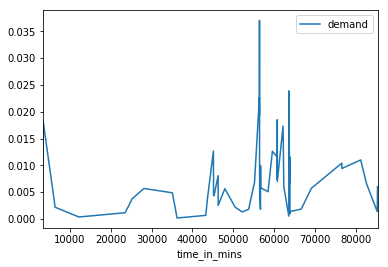

In [180]:
arima_df.plot()

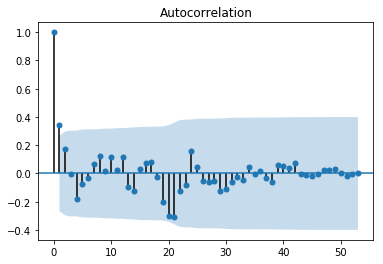

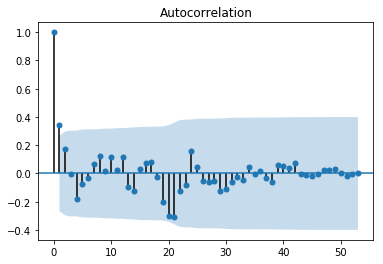

In [181]:
plot_acf(arima_df)

In [182]:
len__ = arima_df.shape[0]

In [183]:
train_size = int(len__*0.7)
test_size = len__- train_size

In [184]:
train = arima_df.iloc[:train_size]
test = arima_df.iloc[train_size:]

In [188]:
model_arima = ARIMA(train,order=(10, 2, 1))
model_arima_fit = model_ar.fit()

In [189]:
predictions= model_arima_fit.forecast(steps=test_size)[0]
# predictions.shape

(17,)

In [190]:
mean_squared_error(test,predictions)

0.0011487444583591383